# Train the CNN/CapsNet, then generate adv examples

In [3]:
%load_ext autoreload
%autoreload 2

In [11]:
import torch
from torch import optim

from datasets import get_mnist_dataset, get_data_loader
from utils import *

from cnn import *
from capsnet import *

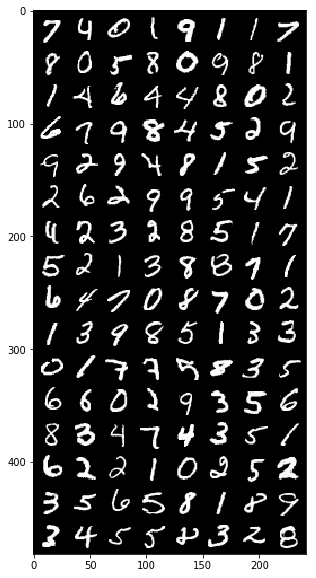

In [2]:
trainset, testset = get_mnist_dataset()
trainloader, testloader = get_data_loader(trainset, testset)
batch, labels = next(iter(trainloader))
plot_batch(batch)

In [4]:
batch_var = Variable(batch.cuda())
labels_var = Variable(one_hotify(labels).cuda())

# Custom tiny CNN

In [198]:
tiny_model = CNN().cuda()
print(count_params(tiny_model))

tiny_optimizer = optim.Adam(tiny_model.parameters())
tiny_loss = nn.CrossEntropyLoss()
tiny_trainer = Trainer(tiny_model, tiny_optimizer, tiny_loss,
                       trainloader, testloader, use_cuda=True)

246506


In [199]:
tiny_trainer.run(epochs=5)

[*] Training for 5 epochs
[*] Epoch 1, TrnLoss: 0.116, TrnAcc: 0.966, TstLoss: 0.062, TstAcc: 0.981
[*] Epoch 2, TrnLoss: 0.039, TrnAcc: 0.988, TstLoss: 0.031, TstAcc: 0.990
[*] Epoch 3, TrnLoss: 0.026, TrnAcc: 0.992, TstLoss: 0.035, TstAcc: 0.989
[*] Epoch 4, TrnLoss: 0.021, TrnAcc: 0.993, TstLoss: 0.029, TstAcc: 0.990
[*] Epoch 5, TrnLoss: 0.018, TrnAcc: 0.994, TstLoss: 0.025, TstAcc: 0.992


# Baseline CNN described in [1]

In [184]:
base_model = BaselineCNN().cuda()
print(count_params(base_model))

base_loss = nn.CrossEntropyLoss()
base_optimizer = optimizer = optim.Adam(base_model.parameters())
base_trainer = Trainer(base_model, base_optimizer, base_loss,
                       trainloader, testloader, use_cuda=True,
                       print_every=50)

35445522


In [185]:
base_trainer.run(epochs=1)

[*] Training for 1 epochs
[*] Batch 0, Loss: 2.304, Acc: 0.086
[*] Batch 50, Loss: 0.441, Acc: 0.867
[*] Batch 100, Loss: 0.323, Acc: 0.898
[*] Batch 150, Loss: 0.165, Acc: 0.945
[*] Batch 200, Loss: 0.141, Acc: 0.969
[*] Batch 250, Loss: 0.080, Acc: 0.977
[*] Batch 300, Loss: 0.138, Acc: 0.945
[*] Batch 350, Loss: 0.141, Acc: 0.961
[*] Batch 400, Loss: 0.077, Acc: 0.984
[*] Batch 450, Loss: 0.071, Acc: 0.984
[*] Batch 0, Loss: 0.006, Acc: 1.000
[*] Batch 50, Loss: 0.030, Acc: 0.984
[*] Epoch 1, TrnLoss: 0.260, TrnAcc: 0.919, TstLoss: 0.048, TstAcc: 0.984


# CapsNet described in [1]

In [116]:
net = CapsuleNetwork().cuda()
decoder = CapsuleDecoder(reconstruction=True, mask_incorrect=True).cuda()
class CapsModel(nn.Module):
    def __init__(self, net, decoder):
        super().__init__()
        self.net = net
        self.decoder = decoder
    
    def forward(self, x, y=None):
        d_caps = self.net(x)
        probs, reconstructions = self.decoder(d_caps, y)
        return probs, reconstructions
caps_model = CapsModel(net, decoder)

print(count_params(net))
print(count_params(caps_model))

caps_loss = CapsuleLoss()
caps_optimizer = optim.Adam(caps_model.parameters())
caps_trainer = Trainer(caps_model, caps_optimizer, caps_loss,
                       trainloader, testloader,
                       one_hot=True, use_reconstructions=True, use_cuda=True,
                       print_every=50)

6804224
8215568


In [60]:
MODEL_PATH = 'trained_capsnet.pth.tar'

In [61]:
caps_trainer.run(epochs=1)
caps_trainer.save_checkpoint(MODEL_PATH)

[*] Training for 5 epochs
[*] Batch 0, Loss: 93.509, Acc: 0.086
[*] Batch 50, Loss: 68.964, Acc: 0.891
[*] Batch 100, Loss: 64.758, Acc: 0.922
[*] Batch 150, Loss: 62.725, Acc: 0.977
[*] Batch 200, Loss: 62.368, Acc: 0.953
[*] Batch 250, Loss: 61.722, Acc: 0.977
[*] Batch 300, Loss: 61.934, Acc: 0.953
[*] Batch 350, Loss: 61.248, Acc: 0.984
[*] Batch 400, Loss: 60.684, Acc: 0.992
[*] Batch 450, Loss: 60.998, Acc: 0.984
[*] Batch 0, Loss: 60.524, Acc: 1.000
[*] Batch 50, Loss: 60.485, Acc: 0.992
[*] Epoch 1, TrnLoss: 63.867, TrnAcc: 0.944, TstLoss: 60.207, TstAcc: 0.985
[*] Batch 0, Loss: 60.716, Acc: 0.992
[*] Batch 50, Loss: 60.959, Acc: 0.984
[*] Batch 100, Loss: 61.056, Acc: 0.977
[*] Batch 150, Loss: 60.265, Acc: 1.000
[*] Batch 200, Loss: 60.448, Acc: 0.992
[*] Batch 250, Loss: 60.594, Acc: 0.992
[*] Batch 300, Loss: 59.898, Acc: 1.000
[*] Batch 350, Loss: 60.194, Acc: 0.984
[*] Batch 400, Loss: 59.806, Acc: 1.000
[*] Batch 450, Loss: 59.987, Acc: 1.000
[*] Batch 0, Loss: 59.779, 

In [117]:
caps_trainer.load_checkpoint(MODEL_PATH)

## Reconstructions

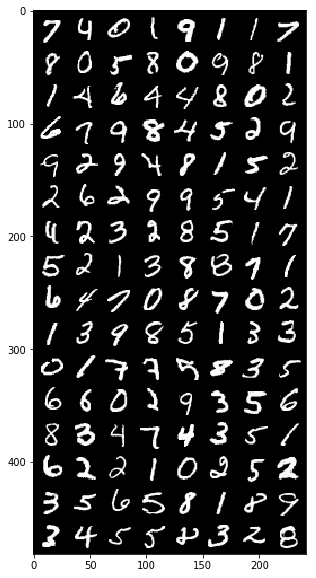

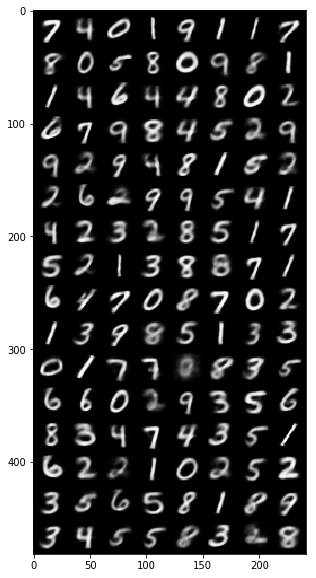

In [118]:
probs, batch_hat = caps_model(batch_var, Variable(one_hotify(labels).cuda()))
plot_batch(batch)
plot_batch(batch_hat.data) # am I messing up the input to the reconstruction network somehow? each class is the same

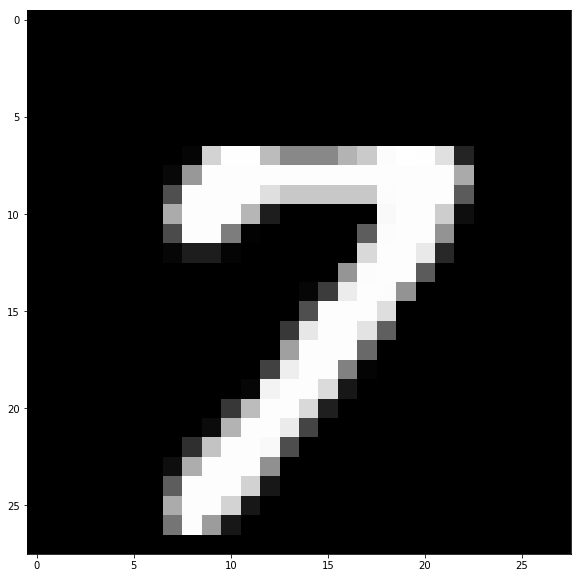

In [149]:
seed_img = batch[0:1]
plot_tensor(seed_img)

In [229]:
from adversarial import Adversary

class CapsuleLogits(nn.Module):
    
    def __init__(self, caps_net):
        super().__init__()
        self.caps_net = caps_net

    def forward(self, x):
        d_caps = self.caps_net(x)
        logits = torch.norm(d_caps, dim=-1)
        return logits

caps_logits = CapsuleLogits(net)
caps_adversary = Adversary(caps_logits)
fool_img = caps_adversary.generate_example(seed_img.cuda(), 2, attack='FGS', eta=0.0005, n_iters=200)

In [238]:
base_adversary = Adversary(base_model)
fool_img = base_adversary.generate_example(seed_img.cuda(), 2, attack='FGS', eta=0.005, n_iters=50)

In [232]:
tiny_adversary = Adversary(tiny_model)
fool_img = tiny_adversary.generate_example(seed_img.cuda(), 2, attack='FGS', eta=0.005, n_iters=50)

Variable containing:
 0.0829  0.0830  0.1097  0.0829  0.0827  0.0826  0.0826  0.2232  0.0830  0.0874
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]



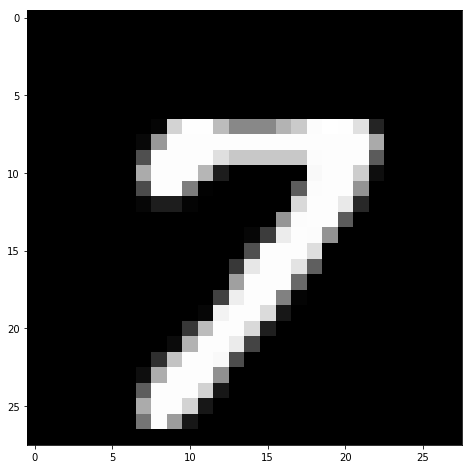

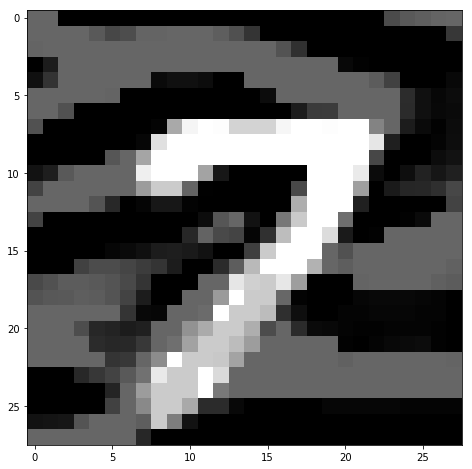

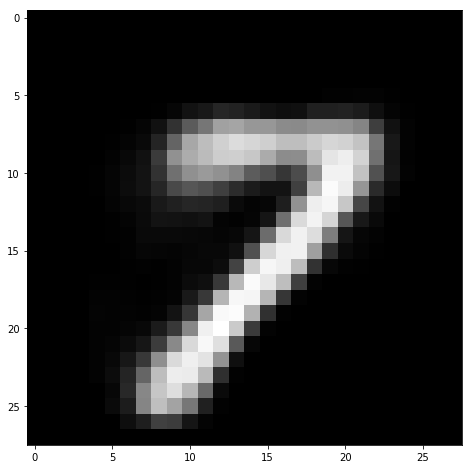

In [239]:
probs, out_img = caps_model(Variable(fool_img))
print(probs)
plot_tensor(seed_img)
plot_tensor(fool_img)
plot_tensor(out_img)

### References

[1] https://arxiv.org/abs/1710.09829